#Load Data

Load csv file and display first 30 entries.

We can observe that dataset contains,
*   ***I-CH*** - imaginary component of the radar data
*   ***Q-CH*** - imaginary component of the radar data
*   Time stamp
*   Sample Number

Following parameters are given,

$\text{Sampling Frequency } (F_s): 4MHz$\
$\text{Azimuth Counter Pulses (ACP) for one revolution: } : 4096$\
$\text{Samples for one ACP cycle: } : 22500$

$\text{Pulse repitition interval (PRI): } : 900\mu s$\
$\text{Transmitted pulse width: } : 14\mu s$\
$\text{Actual pulse transmission and reception time: } : 600\mu s$


In [1]:
import pandas as pd
import io as io
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Radar Assignment 5/dataset.csv')


In [41]:
df.head(10)

,Sample Number,I-CH,Time,Q CH,ACP
0,-524288,7F7B,-26.214308 ms,FF76,0
1,-524287,7F7B,-26.214258 ms,FF76,0
2,-524286,7F7B,-26.214208 ms,FF76,0
3,-524285,7F7B,-26.214158 ms,FF76,0
4,-524284,7F7B,-26.214108 ms,FF76,0
5,-524283,7F6A,-26.214058 ms,FF77,0
6,-524282,7F6A,-26.214008 ms,FF77,0
7,-524281,7F6A,-26.213958 ms,FF77,0
8,-524280,7F6A,-26.213908 ms,FF77,0
9,-524279,7F6A,-26.213858 ms,FF77,0


#Data pre processing



###Downsampling



####Q1

Since we were given the information that this sampled data is oversampled, by observing these printed entries we can see that same value is repeated five times. Hence we can deduce that the oversampling factor should be 5.

After downsampling, the data will be converted to normal sampling frequency, 4 MHz.

Then first 10650 entries has been removed due to errors.

In [4]:
def down_sample(signal_arr,factor,sampling_loc ):
  offset = factor-len(signal_arr)%factor
  dummy_arr = np.zeros(offset).astype('str')
  new_arr = np.append(signal_arr,dummy_arr) #add dummy values so that matrix can be reshaped

  #reshape sample array
  reshape_matrix = new_arr.reshape(int(len(new_arr)/factor),factor)

  #extract required samples and return
  ret_arr =  reshape_matrix[:,sampling_loc]
  return ret_arr

In [5]:
#convert dataframes to np arrays
I_CH_up = df['I-CH'].to_numpy()
Q_CH_up = df['Q CH'].to_numpy()

In [29]:
I_CH = down_sample(I_CH_up,5,0)[10650:] #downsample and remove first 10650 samples
Q_CH = down_sample(Q_CH_up,5,0)[10650:]
time_axis = np.vectorize(lambda x: x[:len(x)-3:1], otypes=[float])(down_sample(df['Time'].to_numpy(),5,0)[10650:])
ACP = down_sample(df['ACP'].to_numpy(),5,0)[10650:]


###Hexadecimal value correction

If MSB of I-CH is '7' then it is changed to 'F'.

In [7]:
#I_channel correction

def hex_correct(channel):
  new_arr = []
  for val in (I_CH): #cheack MSB is 7 and replace it with F
    if val[0]=='7':
      hex_str = 'F'+val[1:]
    else:
      hex_str = val
    new_arr.append(hex_str)
  return np.array(new_arr)

In [8]:
I_CH_corrected = hex_correct(I_CH)

###Convert hexadecimal value to signed integers. 

Since data is stored in two's complement HEX format. Following function is used to convert it to signed decimal integer values. 

In [9]:
def hex_to_dec(hex,bits):
  val=int(hex,bits)
  if (val & (1 << (bits - 1))) != 0: val = val - (1 << bits)  
  return val

arr1=[]
for I_val in I_CH_corrected:
  arr1.append(hex_to_dec(I_val,16))

arr2=[]
for Q_val in Q_CH:
  arr2.append(hex_to_dec(Q_val,16))

Q_CH_processed = np.array(arr2)
I_CH_processed = np.array(arr1)

###Obtain complex sampled radar data.




####Q2

By combining I-CH and Q-CH components, complex radar receiver response signal is obtained.

$W[n] = I_{CH}[n]+jQ_{CH}[n]$

Let's plot $1^{st}$ and $20^{th}$ pulses.

In [10]:
W = I_CH_processed+1j*Q_CH_processed

In [11]:
#forming data matrix

# number of samples for one pulse: (600-14)us * 4MHz
#
#
#2344 pulses
sample_len = 900*4
dataMatrix = W[:int(len(W)/sample_len)*sample_len].reshape(int(len(W)/sample_len),sample_len)

####Q3 
Plot $1^{st}$ and $20^{th}$ pulses to decide the threshold value.

by observing these plots we can set the threshold to 300.

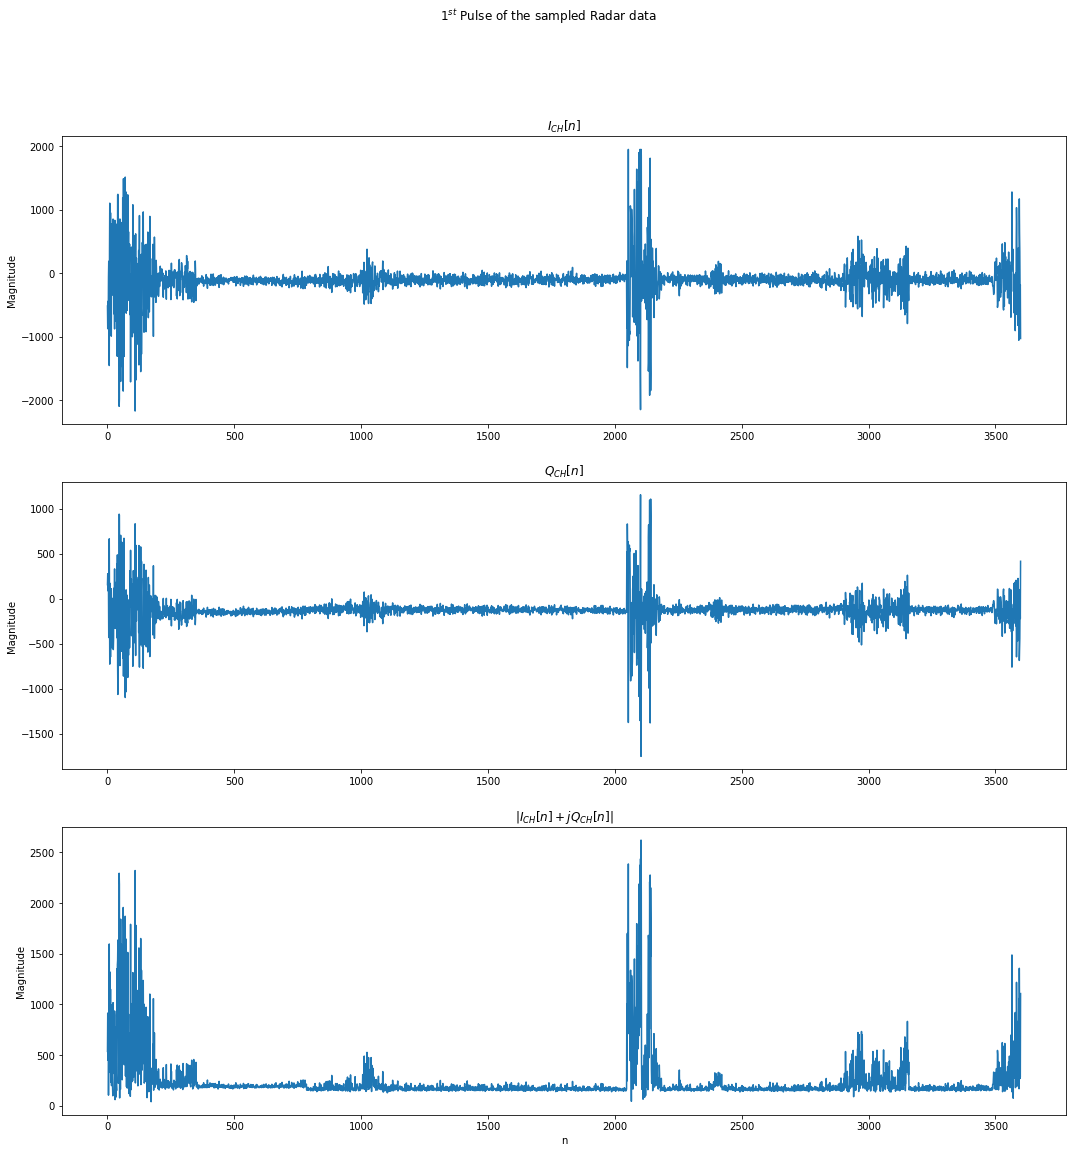

In [12]:
#plot first pulse

f,ax = plt.subplots(3,figsize=(18,18))
f.suptitle('$1^{st}$ Pulse of the sampled Radar data')
ax[0].plot(np.real(dataMatrix[0]))
ax[0].set_title('$I_{CH}[n]$')
ax[0].set( ylabel='Magnitude')

ax[1].plot(np.imag(dataMatrix[0]))
ax[1].set_title('$Q_{CH}[n]$')
ax[1].set( ylabel='Magnitude')

ax[2].plot(np.abs(dataMatrix[0]))
ax[2].set_title('$|I_{CH}[n]+jQ_{CH}[n]|$')
ax[2].set(xlabel='n', ylabel='Magnitude')

plt.show()



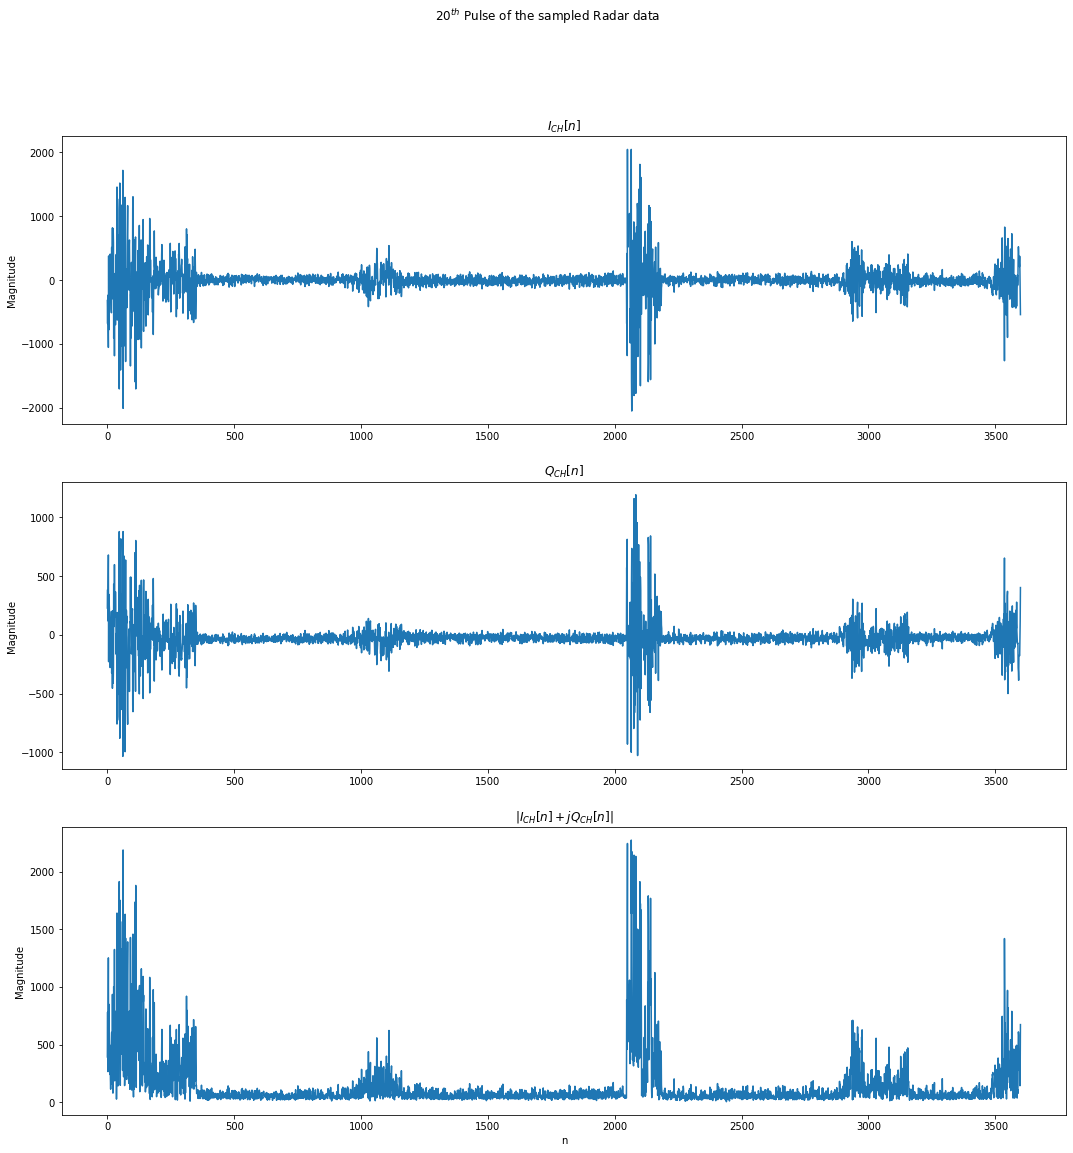

In [13]:
#plot first pulse

f,ax = plt.subplots(3,figsize=(18,18))
f.suptitle('$20^{th}$ Pulse of the sampled Radar data')
ax[0].plot(np.real(dataMatrix[19]))
ax[0].set_title('$I_{CH}[n]$')
ax[0].set( ylabel='Magnitude')

ax[1].plot(np.imag(dataMatrix[19]))
ax[1].set_title('$Q_{CH}[n]$')
ax[1].set( ylabel='Magnitude')

ax[2].plot(np.abs(dataMatrix[19]))
ax[2].set_title('$|I_{CH}[n]+jQ_{CH}[n]|$')
ax[2].set(xlabel='n', ylabel='Magnitude')

plt.show()



In [14]:
threshold = 300

#Obtain Clutter Map



###Q4

We can use this threshold for filtering out data.

obtained matrix contains 3600 samples corresponded to $900\mu s$.
As we were given that first $14 \mu s$ radar blind period, and latter $300\mu s$ is allocated for processing tasks, we have to select data from $14\mu s$ to  $(900 -300) \mu s$ for the radar matrix.

$\therefore \# \text{of samples required starts from } (14\mu s\times 4 MHz) \text{ to } (600\mu s\times 4 MHz)$

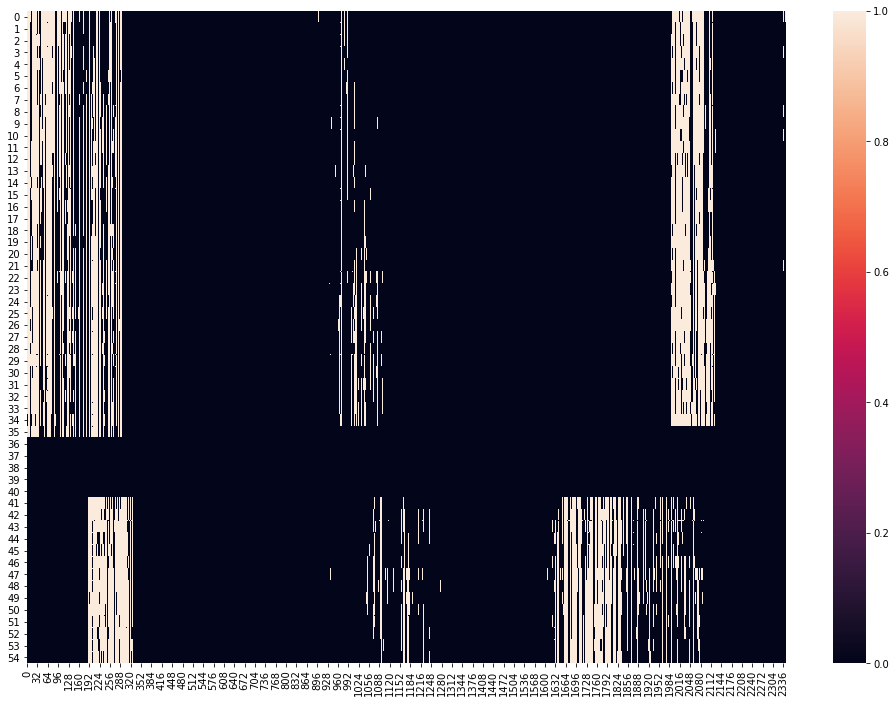

In [15]:
f,ax = plt.subplots(figsize=(17,12))
g2 = sns.heatmap(np.abs(dataMatrix[:,56:2400])>threshold)

#Parameter Estimation

####Q5

#####RPM of RADAR


\begin{align}
\text{Time taken for one revolution} &=  \text{ACPs for one revolution} \times  \text{time for one ACP}\\
&=  \text{ACPs for one revolution} \times  (\text{samples per ACP} \times 
\text{sampling period})\\
&= 4096 \times \left(22500 \times \frac{1}{20\times 10^6}\right)\\
&= 4.608s\\
\therefore \text{RPM of RADAR} &= \frac{60}{4.608} \\&= 13.02 \text{rpm}  
\end{align}


#####Number of echoes per CPI interval

\begin{align}
\# \text{ echoes per CPI interval} &= \text{ACPs for CPI} \times \# \text{ echoes per ACP}\\
&= \text{ACPs for CPI} \times \frac{\text{samples per ACP}}{\text{samples per echo}}\\
&= 32 \times \frac{22500/5}{900\times 4}\\
&=40
\end{align}

#####Beam width of RADAR

\begin{align}
\text{Beam width of RADAR}&= \text{ACPs per azimuth bin} \times {resolution of shaft encoder} \\
&=\text{ACPs per CPI} \times \text{resolution of shaft encoder} \because \text{azimuth bin} = \text{CPI}\\
&= 32 \times \frac{360^\circ}{4096}\\
&=2.81^\circ
\end{align}

#Interpretation


There are two main observations in the obtained clutter map


1.   From 36-40 echoes only the noise level is present
2.   From 40 onwards clutter map shown considerable deviation.

First let's plot time and ACP dataframes for noisy empty echoes







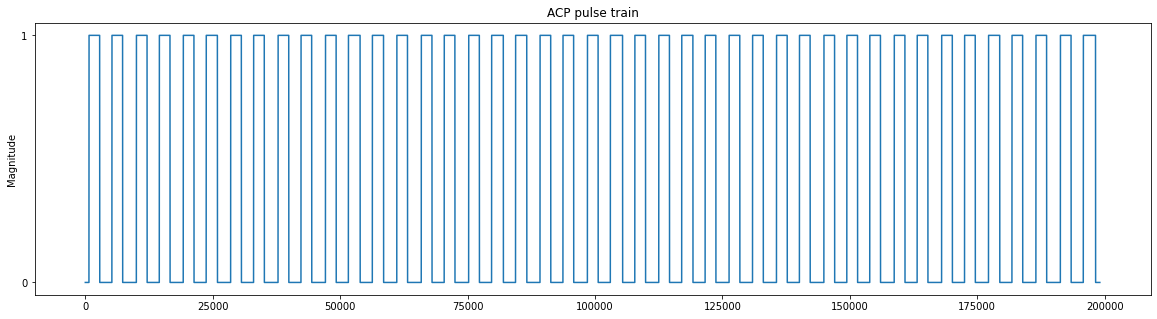

In [66]:
f,ax = plt.subplots(figsize=(20,5))
ax.plot(ACP)
ax.set_title('ACP pulse train')
ax.set( ylabel='Magnitude')
plt.show()

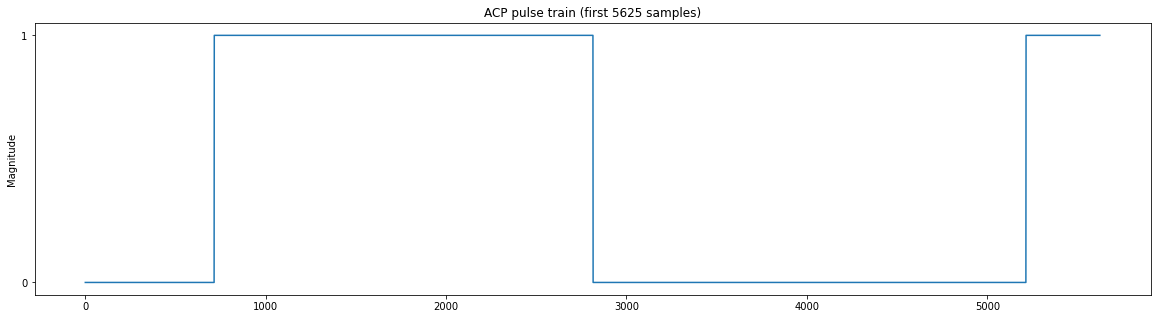

In [69]:
f,ax = plt.subplots(figsize=(20,5))
ax.plot(ACP[:5625])
ax.set_title('ACP pulse train (first 5625 samples)')
ax.set( ylabel='Magnitude')
plt.show()

It seems like ACP encoder also not synchronized. (ideally one cycle should contain $22500/5 = 5625$ samples. but obtained ACP pulse train's cotain less than 5000 samples per ACP cycle.) 

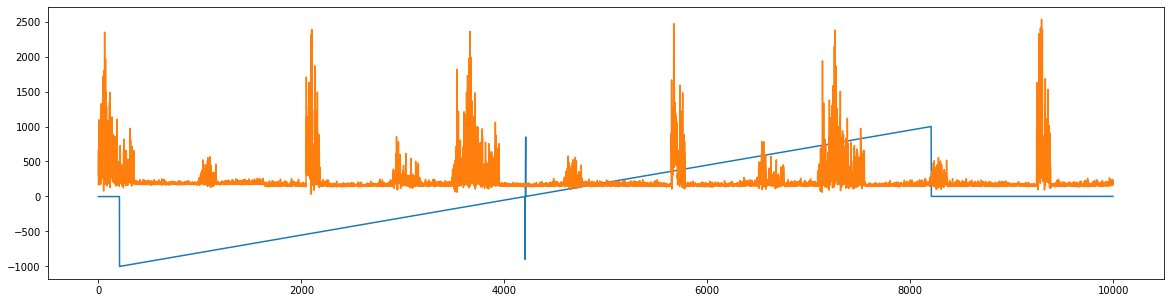

In [70]:
f,ax = plt.subplots(figsize=(20,5))
plt.plot(time_axis[90000:100000])
plt.plot(np.abs(W)[90000:100000])

Time axis is also has some issues. because there is this sudden surge 90,000 - 100,000 range. Reason for that could be the malfunctions with system clock. because observed RADAR pulses has the expected periodicity.

In [57]:
timeMatrix = time_axis[:int(len(W)/sample_len)*sample_len].reshape(int(len(W)/sample_len),sample_len)

Obtained clutter map can be divided in to three main sections. 



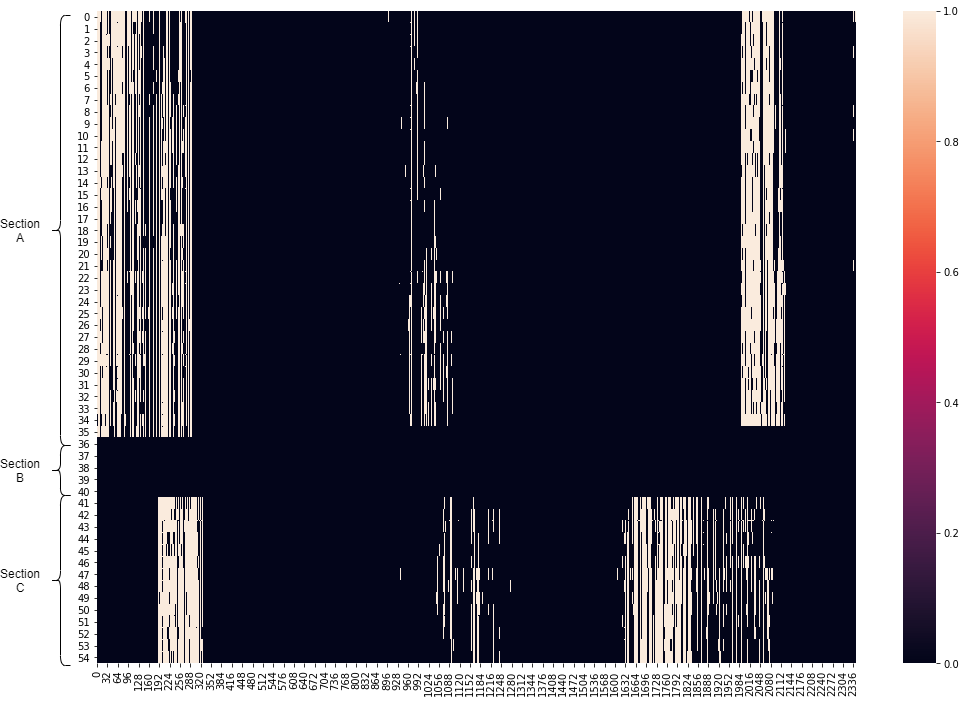

**Section A**: Since we were given that there are no moving targets, this region only contain clutter.

**Section B**: All the received signals are less than noise threshold. reason for that could be the radar vicinity is not illuminated by the transmitter due to malfunctionality in the transmitter.

**Section C**: We can see that clutter map is differ from section A. Since shaft encoder provides pulses with same frequency we can assume that radar is moving at a constant angular velocity. 

Then reason for this anomaly can be either change of surroundings of the radar. But the azimuth change is negligible significant change cannot be expected.

The explanation is as in section B we assume that transmitter is turned off. If this transmitter is turned on between $900\mu s$ interval, then sampling of the signal is differ from section A and as a result we can expect a shift in cluttermap as shown here.

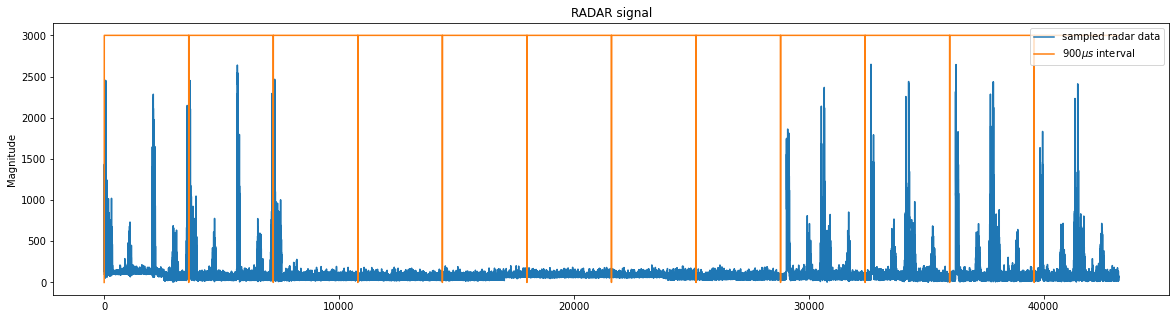

In [94]:
f,ax = plt.subplots(figsize=(20,5))
plt.plot(np.abs(W)[33*3600:45*3600],label='sampled radar data')

echoe_pulse = np.zeros(len(W))
for i in range(len(W)):
  if i%3600:echoe_pulse[i]=3000

plt.plot(echoe_pulse[33*3600:45*3600],label='900$\mu s$ interval')

ax.set_title('RADAR signal')
ax.set( ylabel='Magnitude')
plt.legend(loc='upper right')
plt.show()

By observing previous plot, we can say that tranmitter is turned on in the middle of the $900\mu s$ sample interval. As discussed earlier that could be the reason for the shift in section C.

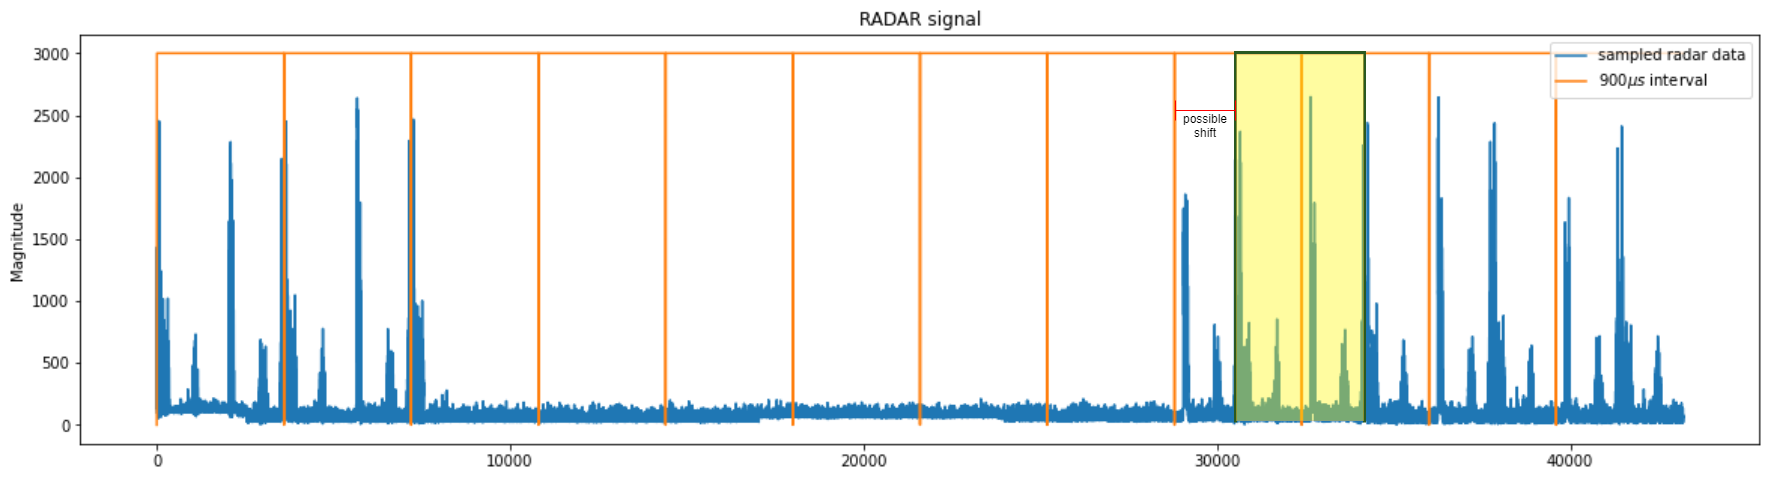